<a href="https://colab.research.google.com/github/jcsmcmendes/Step_Deep_Learning/blob/main/Classification_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 📦 Dataset: CIFAR-10

This **CIFAR-10** dataset is a collection of labeled images and is one of the most basic and widely used datasets for practicing **Machine Learning** and **Computer Vision** techniques.

- It contains **60,000 color images** with a resolution of **32x32 pixels**
- The images are categorized into **10 different classes**:
  - ✈️ Airplanes
  - 🚗 Cars
  - 🐦 Birds
  - 🐱 Cats
  - 🦌 Deer
  - 🐶 Dogs
  - 🐸 Frogs
  - 🐴 Horses
  - 🚢 Ships
  - 🚚 Trucks
- Each class contains **6,000 images**, evenly distributed.

We will implement a neural network model to **classify new (test) images into one of these 10 categories**.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import resize
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Use only 25% of the training and test data to save memory
subset_size_train = int(0.25 * x_train.shape[0])  # 25% of 50,000 = 12,500
subset_size_test = int(0.25 * x_test.shape[0])    # 25% of 10,000 = 2,500

x_train = x_train[:subset_size_train]
y_train = y_train[:subset_size_train]

x_test = x_test[:subset_size_test]
y_test = y_test[:subset_size_test]

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


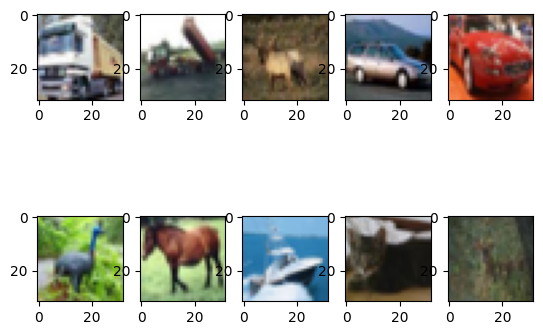

In [4]:
for i in range(1,11):# This 'for' loop iterates from 1 to 10 (inclusive).
  plt.subplot(2, 5, i)# For each value of 'i', it creates a subplot in a 2-row by 5-column grid.
  plt.imshow(x_train[i])# The 'plt.imshow(x_train[i])' function displays the image at position 'i' in the training set 'x_train'.

# The goal is to visualize the first 10 training images, each in its own subplot.

In [5]:
# First we need to normalize the image data by converting the pixel values from integers (0 to 255) to floating-point numbers between 0 and 1.
# This is done by first converting the data type to 'float32', and then dividing each pixel value by 255.
# Normalization helps neural networks train more efficiently and with better performance.
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255


In [6]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape= (32,32,3)),
        tf.keras.layers.Conv2D(32, 3, padding = "valid", activation = "relu"),
        tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
        tf.keras.layers.Conv2D(64, 3, activation = "relu"),
        tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
        tf.keras.layers.Conv2D(128, 3, activation = "relu"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation = "relu"),
        tf.keras.layers.Dense(10),

    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# We need also to configure the model for training.
model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),# 'loss' defines the loss function used to measure how well the model is performing.
    optimizer = keras.optimizers.Adam(),
    metrics =["accuracy"],
    )
# Here, 'SparseCategoricalCrossentropy' is used because the labels are integers (not one-hot encoded), and 'from_logits=True' indicates that the model’s output does not use a softmax activation yet.
# 'optimizer=keras.optimizers.Adam()' specifies the Adam optimizer, which is commonly used and adjusts learning rates automatically. 'metrics=["accuracy"]' tells the model to report accuracy during training and evaluation.

In [8]:
model_history = model.fit(x_train, y_train, batch_size = 64, epochs = 10,verbose = 2)
# This line trains the model using the training data (x_train and y_train).
# 'batch_size=64' means the model will update its weights after processing 64 samples at a time.
# 'epochs=10' means the model will go through the entire training dataset 10 times.
# 'verbose=2' controls the output: it will print one line per epoch with training progress.
# The result, 'model_history', stores information about the training process (e.g., loss and accuracy per epoch).

Epoch 1/10
196/196 - 17s - 85ms/step - accuracy: 0.2959 - loss: 1.8916
Epoch 2/10
196/196 - 20s - 104ms/step - accuracy: 0.4498 - loss: 1.5081
Epoch 3/10
196/196 - 23s - 120ms/step - accuracy: 0.5036 - loss: 1.3683
Epoch 4/10
196/196 - 15s - 75ms/step - accuracy: 0.5531 - loss: 1.2466
Epoch 5/10
196/196 - 21s - 107ms/step - accuracy: 0.5907 - loss: 1.1515
Epoch 6/10
196/196 - 20s - 104ms/step - accuracy: 0.6225 - loss: 1.0711
Epoch 7/10
196/196 - 20s - 103ms/step - accuracy: 0.6535 - loss: 0.9885
Epoch 8/10
196/196 - 15s - 77ms/step - accuracy: 0.6787 - loss: 0.9203
Epoch 9/10
196/196 - 21s - 108ms/step - accuracy: 0.6998 - loss: 0.8636
Epoch 10/10
196/196 - 20s - 101ms/step - accuracy: 0.7266 - loss: 0.7900


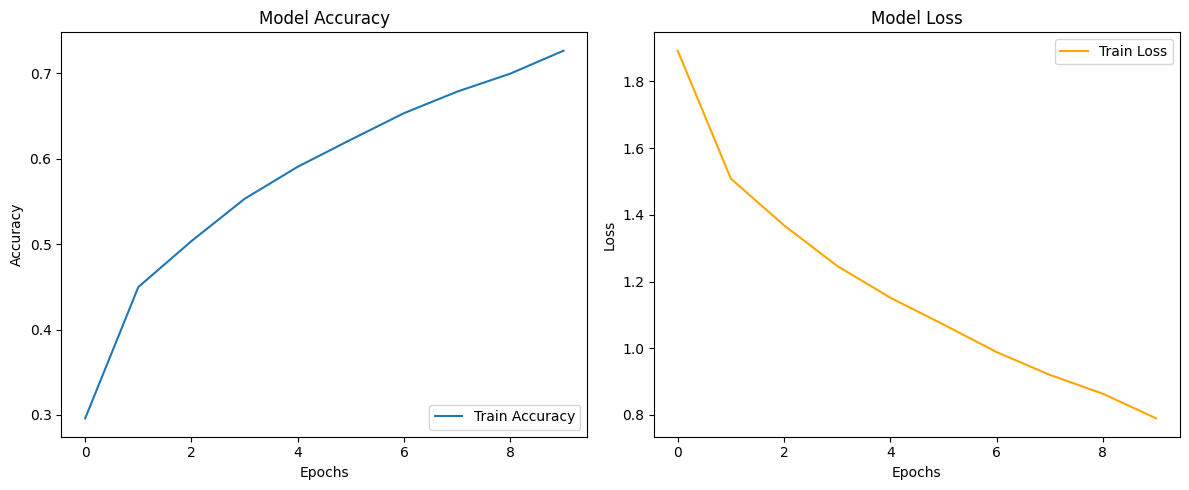

In [11]:
# Create a figure with 1 row and 2 columns for subplots
plt.figure(figsize=(12, 5))  # Set the overall size of the figure

# --- Accuracy plot ---
plt.subplot(1, 2, 1)  # First subplot: 1 row, 2 columns, position 1
plt.plot(model_history.history['accuracy'], label='Train Accuracy')  # Plot training accuracy
plt.title('Model Accuracy')             # Title of the plot
plt.xlabel('Epochs')                    # Label for the x-axis
plt.ylabel('Accuracy')                  # Label for the y-axis
plt.legend(loc='lower right')           # Add a legend in the bottom-right corner

# --- Loss plot ---
plt.subplot(1, 2, 2)  # Second subplot: 1 row, 2 columns, position 2
plt.plot(model_history.history['loss'], label='Train Loss', color='orange')  # Plot training loss
plt.title('Model Loss')                # Title of the plot
plt.xlabel('Epochs')                   # Label for the x-axis
plt.ylabel('Loss')                     # Label for the y-axis
plt.legend(loc='upper right')          # Add a legend in the top-right corner

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


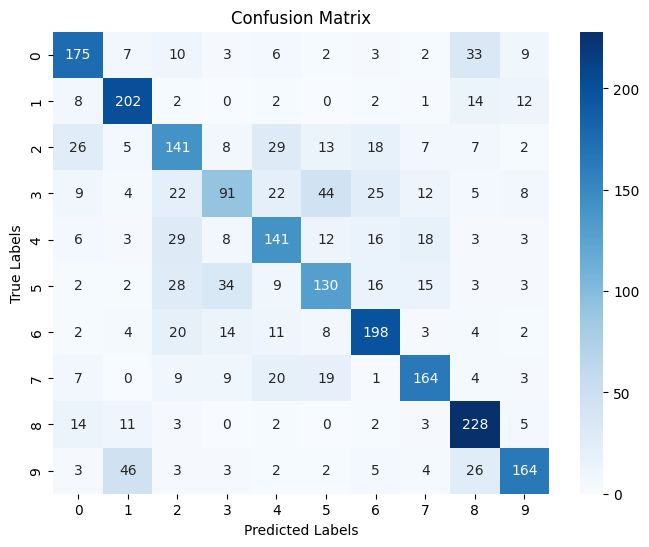

Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.70      0.70       250
           1       0.71      0.83      0.77       243
           2       0.53      0.55      0.54       256
           3       0.54      0.38      0.44       242
           4       0.58      0.59      0.58       239
           5       0.57      0.54      0.55       242
           6       0.69      0.74      0.72       266
           7       0.72      0.69      0.71       236
           8       0.70      0.85      0.77       268
           9       0.78      0.64      0.70       258

    accuracy                           0.65      2500
   macro avg       0.65      0.65      0.65      2500
weighted avg       0.65      0.65      0.65      2500



In [17]:
# Predict class probabilities on the validation set
y_pred_probs = model.predict(x_test)

# Convert predicted probabilities to class labels (index of max probability)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)  # Create the confusion matrix

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # fmt='d' shows integers
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# --- Classification Report ---
report = classification_report(y_test, y_pred)
print("Classification Report:\n")
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Output Label: 8
ship


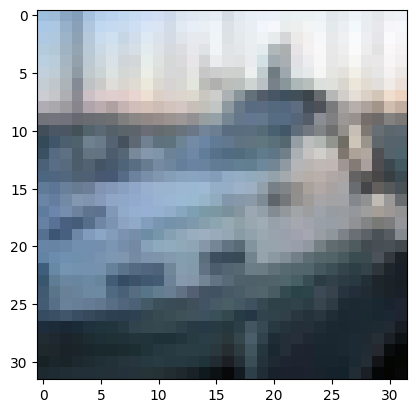

In [18]:
# Display the third image from the test set using matplotlib
plt.imshow(x_test[2])

# Define the list of class labels corresponding to CIFAR-10 dataset categories
labels = ["airplane", "automobile", "bird", "cat", "deer",
          "dog", "frog", "horse", "ship", "truck"]

import cv2  # Import OpenCV library for image processing

# Resize the selected image to 32x32 pixels (in case it's not already)
resized_img = cv2.resize(x_test[2], (32, 32))

# Expand dimensions to match the model's expected input shape (batch_size, height, width, channels)
resized_img = np.expand_dims(resized_img, axis=0)

# Use the trained model to make a prediction on the image
pre = model.predict(resized_img)

# Get the index of the class with the highest probability
n = np.argmax(pre)

# Print the numeric label
print("Output Label:", n)

# Print the corresponding class name using the 'labels' list
print(labels[n])


### 🔁 Transfer Learning with MobileNetV2

In this section, we will use **Transfer Learning** to classify images from the **CIFAR-10** dataset using the **MobileNetV2** architecture.

Instead of training a Convolutional Neural Network from scratch, we will:
- Use a **pretrained MobileNetV2 model** trained on the **ImageNet** dataset (over 1 million images, 1000 classes)
- **Reuse the learned features** from the convolutional base of VGG16
- **Replace the top (dense) layers** with new ones adapted to our task (10 CIFAR-10 classes)
- **Fine-tune** the model or train only the new layers, depending on the configuration

📌 This approach allows us to:
- Save training time
- Improve performance, especially with limited data
- Benefit from features learned on a large and diverse image dataset

We will now proceed to load the pretrained model and prepare it for CIFAR-10 classification.


In [3]:
# Normalize and preprocess
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [4]:
# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [5]:
# Load MobileNetV2 (smaller and efficient), adapted to 32x32 input
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

<ipython-input-5-85353a181699>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Unfreeze last 15 layers
for layer in base_model.layers[-15:]:
    layer.trainable = True


In [8]:
# Add new classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(10, activation='softmax')(x)


In [9]:
# Define the final model
model = Model(inputs=base_model.input, outputs=outputs)


In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 16, 16,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 16, 16,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 16, 16,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 16, 16,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 16, 16,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 16, 16,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 17, 17,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 8, 8, 96)  │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │          0 │ block_1_depthwis… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 8, 8, 24)  │      2,304 │ block_1_depthwis

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 2,236,682 (8.53 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [11]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 105s 179ms/step - accuracy: 0.1142 - loss: 3.2084 - val_accuracy: 0.0980 - val_loss: 2.4428
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 177ms/step - accuracy: 0.1616 - loss: 2.8097 - val_accuracy: 0.0952 - val_loss: 2.7995
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 177ms/step - accuracy: 0.2019 - loss: 2.5731 - val_accuracy: 0.1276 - val_loss: 2.4700
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 84s 181ms/step - accuracy: 0.2318 - loss: 2.4374 - val_accuracy: 0.1372 - val_loss: 2.3459
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 70s 178ms/step - accuracy: 0.2591 - loss: 2.3248 - val_accuracy: 0.1732 - val_loss: 2.2581
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 70s 178ms/step - accuracy: 0.2813 - loss: 2.2600 - val_accuracy: 0.2084 - val_loss: 2.1919
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 175ms/step - accuracy: 0.3016 - loss: 2.1455 - val_accuracy: 0.2584 - val_loss: 2.1108
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 177ms/step - accuracy: 0.3253 - loss: 

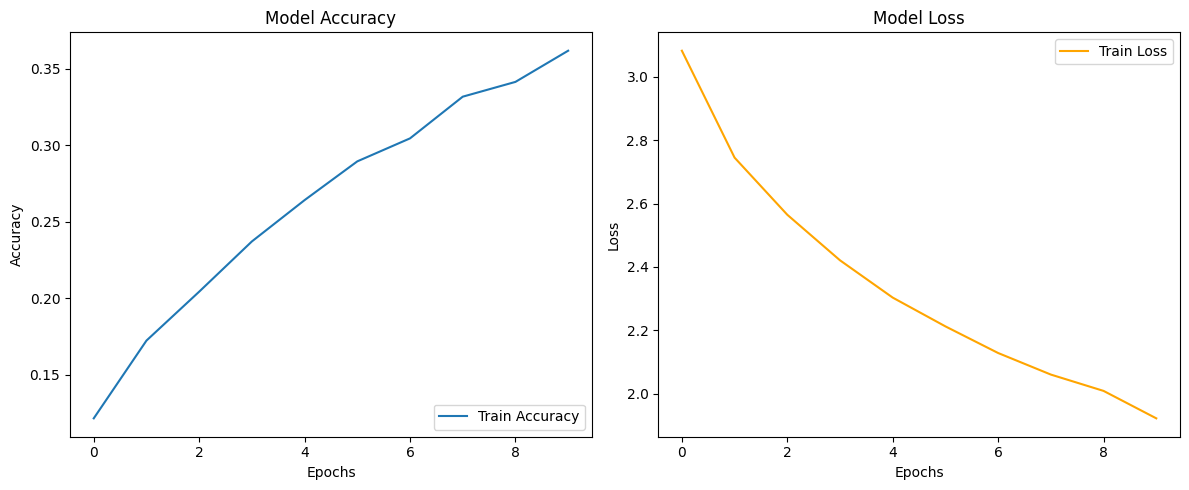

In [12]:
# Create a figure with 1 row and 2 columns for subplots
plt.figure(figsize=(12, 5))  # Set the overall size of the figure

# --- Accuracy plot ---
plt.subplot(1, 2, 1)  # First subplot: 1 row, 2 columns, position 1
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Plot training accuracy
plt.title('Model Accuracy')             # Title of the plot
plt.xlabel('Epochs')                    # Label for the x-axis
plt.ylabel('Accuracy')                  # Label for the y-axis
plt.legend(loc='lower right')           # Add a legend in the bottom-right corner

# --- Loss plot ---
plt.subplot(1, 2, 2)  # Second subplot: 1 row, 2 columns, position 2
plt.plot(history.history['loss'], label='Train Loss', color='orange')  # Plot training loss
plt.title('Model Loss')                # Title of the plot
plt.xlabel('Epochs')                   # Label for the x-axis
plt.ylabel('Loss')                     # Label for the y-axis
plt.legend(loc='upper right')          # Add a legend in the top-right corner

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step


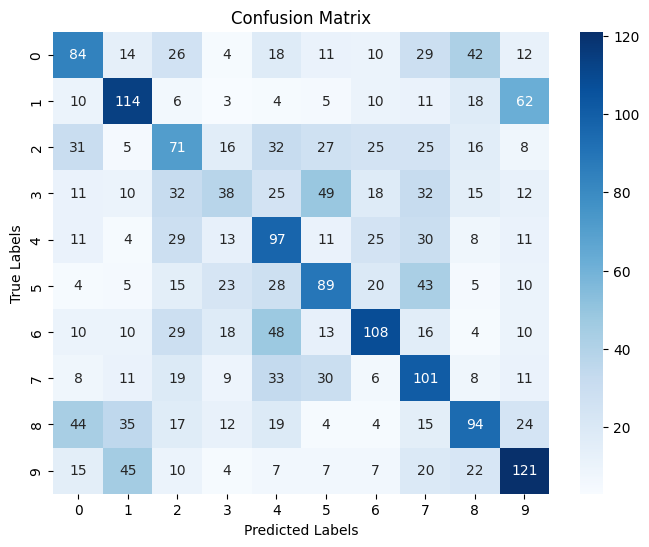

Classification Report:

              precision    recall  f1-score   support

           0       0.37      0.34      0.35       250
           1       0.45      0.47      0.46       243
           2       0.28      0.28      0.28       256
           3       0.27      0.16      0.20       242
           4       0.31      0.41      0.35       239
           5       0.36      0.37      0.36       242
           6       0.46      0.41      0.43       266
           7       0.31      0.43      0.36       236
           8       0.41      0.35      0.38       268
           9       0.43      0.47      0.45       258

    accuracy                           0.37      2500
   macro avg       0.37      0.37      0.36      2500
weighted avg       0.37      0.37      0.36      2500



In [16]:
# Predict class probabilities on the validation set
y_pred_probs = model.predict(x_test)

# Convert predicted probabilities to class labels (index of max probability)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded labels to integer labels
y_test_labels = np.argmax(y_test, axis=1)
# --- Confusion Matrix ---
cm = confusion_matrix(y_test_labels, y_pred)  # Create the confusion matrix

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # fmt='d' shows integers
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# --- Classification Report ---
report = classification_report(y_test_labels, y_pred)
print("Classification Report:\n")
print(report)